In [13]:
using Revise
using Bilevel

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using Plots
using LinearAlgebra
using StaticArrays
using BenchmarkTools
using LaTeXStrings

# Simulation of sliding box

In [ ]:
urdf = joinpath("..", "..", "urdf", "ball2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)

In [ ]:
N = 25
Δt = 0.05
# q0 = [0., 0., 0.]
q0 = [0., 0.2, 0.]
v0 = [10., 0., 0.];

In [ ]:
# Indirect

sim_data = get_sim_data_indirect(mechanism,env,Δt,relax_comp=true)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
sim_indirect = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
@benchmark sim_indirect = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
setanimation!(mvis, sim_indirect[6], sim_indirect[1])

In [ ]:
# Direct

sim_data = get_sim_data_direct(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
sim_direct = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
@benchmark sim_direct = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
setanimation!(mvis, sim_direct[6], sim_direct[1])

In [ ]:
j = 2
plot(sim_indirect[6],sim_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=0,marker=6)
plot!(sim_direct[6],sim_direct[8][j,:],label="Direct",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=4)

In [ ]:
sim_indirect[1][end]

# Trajectory optimization of sliding box

In [25]:
urdf = joinpath("..", "..", "urdf", "ball2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)

In [26]:
# q1 = [0., 0., 0.]
# qN = [4.85, 0., 0.]
# N = 25

q1 = [0., 0.2, 0.]
qN = [5.05, 0., 0.]
N = 20

Δt = 0.05

q_min = [-10., -10., -10.]
q_max = [10., 10., 10.]

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    # torques limits
    add_box_con_snopt!(x_min, x_max, sim_data, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)

    x_min, x_max
end

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, length(q1), x -> vs(x, :q1) - q1)
    add_eq!(sim_data, :cv1, 1, x -> vs(x, :v1)[2])
    add_eq!(sim_data, :cqN, 2, x -> vs(x, Symbol("q", N))[1:2] - qN[1:2])
    add_eq!(sim_data, :cvN, 1, x -> vs(x, Symbol("v", N))[1])
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        x0[sim_data.vs(Symbol("q", n))] .= n/N*(qN - q1) + q1
    end
    
    x0
end

get_prob_init (generic function with 1 method)

In [32]:
# Indirect
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=true)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)

@time traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

Finished successfully: optimality conditions satisfied
 50.488197 seconds (126.09 M allocations: 10.067 GiB, 22.96% gc time)


(Array{Float64,1}[[0.0, 0.2, 0.0], [0.534192, 0.175542, -0.0826732], [1.06858, 0.126708, -0.165346], [1.60315, 0.0535822, -0.24802], [2.08627, 2.18535e-17, -0.330693], [2.47786, 0.0, -0.413366], [2.84126, 3.33163e-5, -0.496039], [3.17674, -4.15644e-5, -0.578712], [3.48414, 0.0, -0.661386], [3.76353, 0.00016858, -0.744059], [4.01557, 0.0, -0.826732], [4.23977, 9.80838e-19, -0.909405], [4.43642, 8.60533e-19, -0.992078], [4.60563, -2.18029e-6, -1.07475], [4.74741, 6.19721e-5, -1.15742], [4.86206, 2.49845e-5, -1.2401], [4.94959, -3.79118e-5, -1.32277], [5.00995, -1.58954e-18, -1.40544], [5.04341, 0.0, -1.48812], [5.05, 0.0, -1.57079]], Array{Float64,1}[[10.6799, 0.0, -1.65346], [10.6877, 0.394765, -1.65346], [10.7027, 0.795781, -1.65346], [10.7233, 1.20682, -1.65346], [9.48674, 2.12376, -1.65346], [7.17226, 3.14603, -1.65346], [6.39176, 3.45979, -1.65346], [5.61787, 3.66853, -1.65346], [4.85102, 3.77673, -1.65346], [4.10887, 3.78704, -1.65346], [3.41659, 3.70641, -1.65346], [2.75412, 3.538

In [33]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

BenchmarkTools.Trial: 
  memory estimate:  277.75 MiB
  allocs estimate:  1584316
  --------------
  minimum time:     222.444 ms (0.00% GC)
  median time:      226.933 ms (0.00% GC)
  mean time:        260.554 ms (0.00% GC)
  maximum time:     713.777 ms (0.00% GC)
  --------------
  samples:          20
  evals/sample:     1

In [30]:
# Semidirect
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)
@time traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

Finished successfully: optimality conditions satisfied
  1.611604 seconds (13.82 M allocations: 1.977 GiB)


(Array{Float64,1}[[0.0, 0.2, 0.0], [0.491219, 0.175732, 0.0824386], [0.978773, 0.127279, 0.164877], [1.46268, 0.0547196, 0.247316], [1.90746, 9.77139e-14, 0.329754], [2.28193, 0.0, 0.412193], [2.63253, 0.0, 0.494632], [2.9593, 0.0, 0.57707], [3.26229, -3.88748e-19, 0.659509], [3.54151, 0.0, 0.741948], [3.79716, 0.0, 0.824386], [4.02934, 0.0, 0.906825], [4.23812, 0.0, 0.989263], [4.42355, 0.0, 1.0717], [4.58571, 3.58057e-19, 1.15414], [4.72462, -1.73472e-18, 1.23658], [4.84043, -9.91508e-14, 1.31902], [4.93315, 8.331e-5, 1.40146], [5.00287, 0.000210335, 1.4839], [5.05, 0.0, 1.56633]], Array{Float64,1}[[9.89804, 0.0, 1.64877], [9.75105, -1.2927, 1.64877], [9.45977, -2.55639, 1.64877], [9.02836, -3.77624, 1.64877], [8.06202, -3.91594, 1.64877], [6.86217, -3.00042, 1.64877], [6.17145, -3.32859, 1.64877], [5.47712, -3.56555, 1.64877], [4.78902, -3.71301, 1.64877], [4.11651, -3.77347, 1.64877], [3.47189, -3.75374, 1.64877], [2.86159, -3.65704, 1.64877], [2.2936, -3.4891, 1.64877], [1.7751, -

In [31]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

BenchmarkTools.Trial: 
  memory estimate:  92.04 MiB
  allocs estimate:  505654
  --------------
  minimum time:     56.876 ms (0.00% GC)
  median time:      65.050 ms (0.00% GC)
  mean time:        72.422 ms (0.00% GC)
  maximum time:     115.467 ms (0.00% GC)
  --------------
  samples:          70
  evals/sample:     1

In [ ]:
j = 1
xlabel=latexstring("t")
ylabel=latexstring("x")
plot(traj_indirect[7],traj_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel)
plot!(traj_semidirect[7],traj_semidirect[8][j,:],label="Semidirect",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=6,ylabel=ylabel)

In [69]:
savefig(string("slidingbox_x.svg")) 

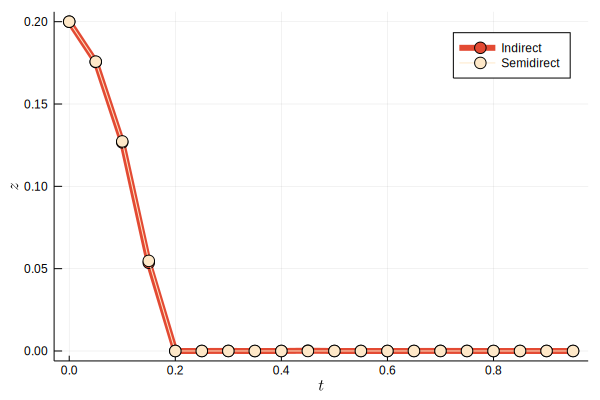

In [59]:
j = 2
xlabel=latexstring("t")
ylabel=latexstring("z")
plot(traj_indirect[7],traj_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel)
plot!(traj_semidirect[7],traj_semidirect[8][j,:],label="Semidirect",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=6,ylabel=ylabel)

In [61]:
savefig(string("slidingbox_z.svg")) 

In [66]:
display(traj_indirect[2][end])
display(traj_semidirect[2][end])

3-element Array{Float64,1}:
  0.0                
  0.13189637992344708
 -1.6534639300448033 

3-element Array{Float64,1}:
  0.0               
 -0.9395249723248388
  1.6531350959668225

In [67]:
display(length(traj_indirect[9]))
display(length(traj_semidirect[9]))

367

215

# Trajectory optimization of little dog

In [14]:
urdf = joinpath("..", "..", "urdf", "little_dog", "little_dog2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 100.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [15]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));
open(mvis)

Could not open browser automatically: ErrorException("failed process: Process(`xdg-open http://127.0.0.1:8701`, ProcessExited(3)) [3]")
Please open the following URL in your browser:
http://127.0.0.1:8701


┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8701
└ @ MeshCat /home/blandry/.julia/packages/MeshCat/WlA0B/src/servers.jl:24
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'http://127.0.0.1:8701'


In [16]:
N = 8
Δt = 0.025
q0 = [0., -.275, 0., 0., 0., 0., 0., pi/4, pi/4, -pi/4, -pi/4, -pi/2, -pi/2, pi/2, pi/2] 
v0 = zeros(num_velocities(mechanism))

sim_data = get_sim_data_indirect(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
traj_sim = Bilevel.simulate(sim_data,null_ctrl!,x0,N)
setanimation!(mvis, traj_sim[6], traj_sim[1])

Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")
Stacktrace:
 [1] try_yieldto(::typeof(Base.ensure_rescheduled), ::Base.RefValue{Task}) at ./event.jl:196
 [2] wait() at ./event.jl:255
 [3] wait(::Condition) at ./event.jl:46
 [4] wait(::Task) at ./task.jl:188
 [5] create_socket(::Dict{Any,Any}) at /home/blandry/.julia/packages/WebIO/Rk8wc/src/providers/mux.jl:44
 [6] (::getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(WebIO.create_socket)})(::Function, ::Dict{Any,Any}) at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:17
 [7] #1 at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:10 [inlined]
 [8] splitquery(::getfield(Mux, Symbol("##1#2")){getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(WebIO.create_socket)},getfield(Mux, Symbol("##1#2")){typeof(Mux.wclose),getfield(Mux, Symbol("##1#2")){getfield(Mux, Symbol(

In [17]:
q_nom = copy(traj_sim[1][end])
q_min = min.(q_nom, [-5., -.5, -.2*pi, 0., 0., 0., 0., -3.5, -3.5, -3.5, -3.5, -3.1, -3.1, -3.1, -3.1])
q_max = max.(q_nom, [5., -0.1, .2*pi, 0., 0., 0., 0., 2.4, 2.4, 2.4, 2.4, 1., 1., 1., 1.])

x_goal = 0.05

N = 10
Δt = 0.1

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, 2, x -> vs(x, :q1)[1:2] - q_nom[1:2])
    add_eq!(sim_data, :cv1, num_velocities(mechanism), x -> vs(x, :v1))
    add_ineq!(sim_data, :cqNx, 1, x -> x_goal - vs(x, Symbol("q", N))[1])
    add_eq!(sim_data, :cqNlegs, num_positions(mechanism)-1, x -> vs(x, Symbol("q", N))[2:end] - vs(x, :q1)[2:end])
    add_eq!(sim_data, :cvN, num_velocities(mechanism), x -> vs(x, Symbol("v", N)))
end

function add_prob_obj!(sim_data)
    for n = 1:N-1
        add_obj!(sim_data, Symbol("u", n), x -> sim_data.vs(x, Symbol("u", n))' * sim_data.vs(x, Symbol("u", n)))
    end
end

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    # torques limits
    u_limit = 10.
    add_box_con_snopt!(x_min, x_max, sim_data, :u, -u_limit * ones(num_velocities(mechanism)), u_limit * ones(num_velocities(mechanism)), 1:N-1)
    
    x_min, x_max
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        qn = copy(q_nom)
        qn[1] = (n/N)*(x_goal - q_nom[1]) + q_nom[1]
        x0[sim_data.vs(Symbol("q", n))] .= qn
    end
    
    x0
end

function setup_prob!(sim_data)
    add_prob_constraints!(sim_data)
    add_prob_obj!(sim_data)
    x_min, x_max = get_prob_limits(sim_data)
    x0 = get_prob_init(sim_data)
    
    x0, x_min, x_max
end

setup_prob! (generic function with 1 method)

In [ ]:
# Indirect

sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data);

In [ ]:
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

display(@time traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter))

x0 = traj_indirect[9]

setanimation!(mvis, traj_indirect[7], traj_indirect[1])

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

In [9]:
setanimation!(mvis, traj_indirect[7], traj_indirect[1])

UndefVarError: UndefVarError: traj_indirect not defined

In [ ]:
t_step = traj_indirect[7]
q_step = traj_indirect[1]
u_step = traj_indirect[2][2:end];

In [18]:
# Semidirect

sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data);

In [19]:
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

display(@time traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter))

x0 = traj_semidirect[9]

setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

(Array{Float64,1}[[3.52047e-7, -0.102648, 0.0187562, -0.0163137, 0.0319144, -0.0140417, 0.0225813, 0.716478, 0.47746, -0.685961, -0.514816, -2.11871, -1.99082, 2.0422, 1.95243], [0.00374469, -0.10407, 0.0452362, -0.0122809, 0.0264977, -0.0229385, 0.0284594, 0.709852, 0.475147, -0.714119, -0.545073, -2.1405, -2.02269, 2.00374, 1.91223], [0.00991062, -0.10837, 0.0472779, -0.0150902, 0.0236347, -0.026822, 0.0290156, 0.735771, 0.507113, -0.732138, -0.558167, -2.10814, -1.99766, 1.95691, 1.87156], [0.0172652, -0.117131, 0.0477669, -0.0276495, 0.0242243, -0.0323679, 0.0299162, 0.794038, 0.577222, -0.788801, -0.609584, -2.03111, -1.93706, 1.87385, 1.799], [0.0250693, -0.120835, 0.0387656, -0.0302253, 0.0200893, -0.032346, 0.0294994, 0.821159, 0.628886, -0.818568, -0.651243, -1.97901, -1.90301, 1.84964, 1.79137], [0.0335751, -0.112454, 0.0282558, -0.0267344, 0.025795, -0.00971238, 0.0119399, 0.769673, 0.565591, -0.802957, -0.639338, -2.04771, -1.95153, 1.96371, 1.89587], [0.0419742, -0.109287,

Finished successfully: optimality conditions satisfied
 12.860743 seconds (39.06 M allocations: 19.451 GiB, 28.50% gc time)


In [ ]:
set_configuration!(mvis, traj_semidirect[1][10])

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

In [ ]:
maximum(abs.(vcat(traj_semidirect[3]...)))

In [ ]:
cntraj = hcat(traj_semidirect[5]...)
front_traj = cntraj[1,:] .+ cntraj[2,:]
back_traj = cntraj[3,:] .+ cntraj[4,:];

In [ ]:
xlabel=latexstring("t")
ylabel=latexstring("c_n")
plot(traj_semidirect[7][1:end-1],front_traj,label="Front legs",seriescolor=RGB(((227,174,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel)
plot!(traj_semidirect[7][1:end-1],back_traj,label="Back legs",seriescolor=RGB(((154,132,200) ./ 255.)...),linewidth=6,marker=6,ylabel=ylabel)

In [ ]:
savefig(string("littledog.svg")) 

In [ ]:
xlabel=latexstring("x")
ylabel=latexstring("z")
plot(traj_semidirect[8][1,:],-traj_semidirect[8][2,:],front_traj,label="Torso center of mass position",seriescolor=RGB(((127,174,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel,ylabel=ylabel)

In [ ]:
savefig(string("littledogcom.svg")) 

In [10]:
setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

In [22]:
t_step = traj_semidirect[7]
q_step = traj_semidirect[1]
u_step = traj_semidirect[2][2:end];

In [24]:
# Multi-steps

reps = 10

ttraj = t_step
qtraj = q_step
utraj = u_step
for i = 1:(reps-1)
    ttraj = vcat(ttraj, t_step .+ ttraj[end])
    qtraj = vcat(qtraj, map(q -> q + vcat(qtraj[end][1],zeros(length(q)-1)), q_step))
    utraj = vcat(utraj, u_step)
end

setanimation!(mvis, ttraj, qtraj)